### Preprocessing


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import tarfile
from google.colab import drive

tar = tarfile.open("/content/drive/My Drive/Colab Notebooks/datasets/grozi120.tar.gz", "r")
tar.extractall('/content')

In [2]:
import os
import pandas as pd
dataset_path = '/content/grozi120'
new_path = '/content/grozi120/processed'

In [3]:
if not os.path.exists(os.path.join(new_path, 'inVitro')):
  os.makedirs(os.path.join(new_path, 'inVitro'))

labels = {}
with open(os.path.join(dataset_path, 'UPC_index.txt'), 'r') as f:
  lines = [line.rstrip() for line in f.readlines()[1:] if line != '\n']
  for i in range(0, len(lines)-2, 3):
    labels[int(lines[i])] = [lines[i+1], lines[i+2]]

dataset = {
  'file_name': [], 
  'label': []
}
for product in os.listdir(os.path.join(dataset_path, 'inVitro')):
  for product_file in os.listdir(os.path.join(dataset_path, 'inVitro', product, 'web', 'JPEG')):
    if product_file == 'Thumbs.db':
      continue
    dataset['file_name'].append(os.path.join(dataset_path, 'inVitro', product, 'web', 'JPEG', product_file))
    dataset['label'].append(labels[int(product)][1])

df = pd.DataFrame(dataset, columns=['file_name', 'label'])

In [4]:
import csv
from shutil import copyfile

if not os.path.exists(os.path.join(new_path, 'inSitu')):
    os.makedirs(os.path.join(new_path, 'inSitu'))

evaluation_dataset = {
  'file_name': [], 
  'label': []
}

for product in os.listdir(os.path.join(dataset_path, 'inSitu')):
    for product_file in os.listdir(os.path.join(dataset_path, 'inSitu', product, 'video')):
        if product_file == 'Thumbs.db':
            continue
        evaluation_dataset['file_name'].append(os.path.join(dataset_path, 'inSitu', product, 'video', product_file))
        evaluation_dataset['label'].append(labels[int(product)][1])

evaluation_df = pd.DataFrame(evaluation_dataset, columns=['file_name', 'label'])

with open(os.path.join(new_path, 'inSitu', 'evaluation.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(evaluation_dataset['file_name'], evaluation_dataset['label']):
        split = file_name.split('/')
        dataset_writer.writerow(['{}_{}'.format(split[-3], split[-1]), label])
        copyfile(file_name, os.path.join(new_path, 'inSitu','{}_{}'.format(split[-3], split[-1])))

In [7]:
from sklearn.model_selection import train_test_split

train_filenames, validation_filenames, train_labels, validation_labels = train_test_split(df['file_name'], df['label'], train_size=0.75, random_state=42, stratify=df['label'])

if not os.path.exists(os.path.join(new_path, 'inVitro', 'train')):
    os.makedirs(os.path.join(new_path, 'inVitro', 'train'))
with open(os.path.join(new_path, 'inVitro', 'train.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(train_filenames, train_labels):
        split = file_name.split('/')
        dataset_writer.writerow(['{}_{}'.format(split[-4], split[-1]), label])
        copyfile(file_name, os.path.join(new_path, 'inVitro', 'train','{}_{}'.format(split[-4], split[-1])))

if not os.path.exists(os.path.join(new_path, 'inVitro', 'validation')):
    os.makedirs(os.path.join(new_path, 'inVitro', 'validation'))
with open(os.path.join(new_path, 'inVitro', 'validation.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(validation_filenames, validation_labels):
        split = file_name.split('/')
        dataset_writer.writerow(['{}_{}'.format(split[-4], split[-1]), label])
        copyfile(file_name, os.path.join(new_path, 'inVitro', 'validation','{}_{}'.format(split[-4], split[-1])))
    

## Defining data augmentations

In [8]:
import cv2
import numpy as np

def training_data(file, path):
  global W_SUM
  global H_SUM
  img = cv2.imread(os.path.join(path, file),cv2.IMREAD_COLOR)
  shape = np.array(img).shape
  W_SUM += shape[0]
  H_SUM += shape[1]
  img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
  X.append(np.array(img))

def invert_image(img):
  return (255-img)

210.31656804733728
192.91272189349112
Found 507 validated image filenames belonging to 120 classes.
Found 169 validated image filenames belonging to 120 classes.
Found 11194 validated image filenames belonging to 120 classes.


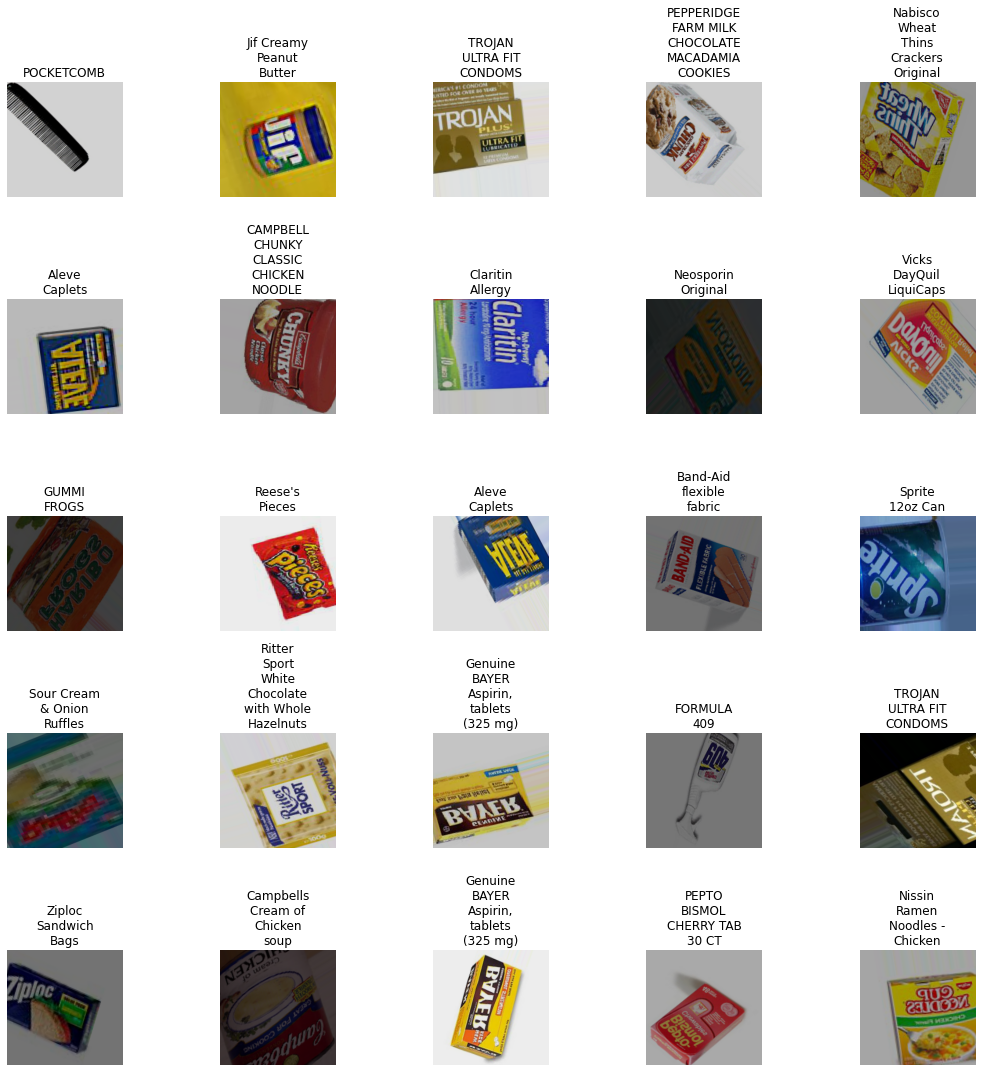

In [10]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from keras_preprocessing.image import ImageDataGenerator
from numpy import argmax
from textwrap import wrap

IMG_SIZE = 200
BATCH_SIZE = 128

train_df = pd.read_csv(os.path.join(new_path, 'inVitro', 'train.csv'))
validation_df = pd.read_csv(os.path.join(new_path, 'inVitro', 'validation.csv'))
evaluation_df = pd.read_csv(os.path.join(new_path, 'inSitu', 'evaluation.csv'))

X = []
global W_SUM
global H_SUM
W_SUM = 0
H_SUM = 0
for file in train_df['file_name']:
  training_data(file, path = os.path.join(new_path, 'inVitro', 'train'))

for file in validation_df['file_name']:
  training_data(file, path = os.path.join(new_path, 'inVitro', 'validation'))
  
X = np.array(X)
X=X/255

print(W_SUM / X.shape[0])
print(H_SUM / X.shape[0])
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=90,  
    zoom_range = 0.2,
    shear_range = 0.2,
    width_shift_range=0.2,  
    height_shift_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,  
    vertical_flip=True,
    rescale=1. / 255)

train_datagen.fit(X)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

validation_datagen.fit(X)

evaluation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=os.path.join(new_path, 'inVitro', 'train'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow_from_dataframe(dataframe=validation_df, directory=os.path.join(new_path, 'inVitro', 'validation'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

evaluation_generator  = evaluation_datagen.flow_from_dataframe(dataframe=evaluation_df, directory=os.path.join(new_path, 'inSitu'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

x,y = train_generator.next()

fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
num = 0
for i in range(5):
  for j in range (5):
    ax[i,j].imshow(x[num])
    mydict = evaluation_generator.class_indices
    inverted = list(mydict.keys())[list(mydict.values()).index(argmax(y[num]))]
    ax[i,j].set_title("\n".join(wrap(inverted, 10)))
    ax[i,j].axis('off')
    num += 1
  num += 1
        
plt.tight_layout()

In [9]:
evaluation_generator.class_indices

{'26OZ BLUE WINDEX': 0,
 'A-1 STEAK SAUCE': 1,
 'ARM + HAMMER BAKING SODA': 2,
 'AVIATOR POKER CARDS': 3,
 "Act II Butter Lover's Popcorn": 4,
 'Aleve Caplets': 5,
 'Always thin pantiliners': 6,
 'BEEF JERKY': 7,
 'Band-Aid flexible fabric': 8,
 'Bausch & Lomb Renu All in One Multi Purpose Solution': 9,
 "Ben & Jerry's Ice Cream World's Best Vanilla": 10,
 'Blistex "Silk & Shine" Lip gloss and sunscreen SPF 15': 11,
 "Bull's-Eye BBQ Sauce Original": 12,
 'CAMPBELL CHUNKY CLASSIC CHICKEN NOODLE': 13,
 'CARMEX EZ-ON APPLICATOR': 14,
 'CLOROX 2 LIQUID 44 OZ': 15,
 'CLOROX ULTRA LIQUID REG': 16,
 "Campbell's Tomato Soup - Microwavable bowl": 17,
 'Campbells Cream of Chicken soup': 18,
 'Certs Peppermint': 19,
 'Chap Stick Lip Balm': 20,
 'Cheez-It': 21,
 'Chef Boyardee Beef Ravioli': 22,
 'Chex Mix': 23,
 'Claritin Allergy': 24,
 'Crystal Geyser Water': 25,
 'DENTYNE ICE ARTIC CHILL': 26,
 'David Sunflower Seeds': 27,
 'Diet Coke with Lime': 28,
 'Dove Anti-Perspirant/Deodorant Fresh Invis

In [62]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet',
                                         )

In [63]:
base_model.trainable = False
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_597 (Conv2D)             (None, 99, 99, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_597 (BatchN (None, 99, 99, 32)   96          conv2d_597[0][0]                 
__________________________________________________________________________________________________
activation_596 (Activation)     (None, 99, 99, 32)   0           batch_normalization_597[0][0]    
________________________________________________________________________________

In [64]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
global_max_layer = tf.keras.layers.GlobalMaxPooling2D()
dropout_layer = tf.keras.layers.Dropout(0.4)
prediction_layer = tf.keras.layers.Dense(120, activation='softmax')

In [65]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC, CategoricalCrossentropy
from tensorflow_addons.metrics import F1Score

num_classes = len(train_generator.class_indices)
metrics = [CategoricalAccuracy(name='categorical_accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    CategoricalCrossentropy(label_smoothing=0.3),
    F1Score(name='f1score',num_classes=num_classes)]

In [66]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dropout_layer,
  prediction_layer
])

base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1536)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               184440    
Total params: 54,521,176
Trainable params: 184,440
Non-trainable params: 54,336,736
_________________________________________________________________


In [79]:
num_epochs = 100

history = model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator)

Epoch 1/100
4/4 [==============================] - 8s 2s/step - loss: 0.5617 - categorical_accuracy: 0.9014 - precision: 0.9751 - recall: 0.6963 - auc: 0.9993 - categorical_crossentropy: 3.5420 - f1score: 0.8966 - val_loss: 1.0118 - val_categorical_accuracy: 0.7811 - val_precision: 0.9196 - val_recall: 0.6095 - val_auc: 0.9807 - val_categorical_crossentropy: 3.7049 - val_f1score: 0.7167
Epoch 2/100
4/4 [==============================] - 8s 2s/step - loss: 0.5561 - categorical_accuracy: 0.8856 - precision: 0.9709 - recall: 0.7239 - auc: 0.9992 - categorical_crossentropy: 3.5608 - f1score: 0.8816 - val_loss: 1.0016 - val_categorical_accuracy: 0.7870 - val_precision: 0.9364 - val_recall: 0.6095 - val_auc: 0.9807 - val_categorical_crossentropy: 3.7046 - val_f1score: 0.7236
Epoch 3/100
4/4 [==============================] - 8s 2s/step - loss: 0.5704 - categorical_accuracy: 0.8797 - precision: 0.9838 - recall: 0.7199 - auc: 0.9983 - categorical_crossentropy: 3.5498 - f1score: 0.8773 - val_lo

In [78]:
import json

hist_df = pd.DataFrame(history.history) 

# save history to json:  
hist_json_file = '/content/drive/My Drive/Colab Notebooks/models/grozi120/history/InceptionResNetV2_imagenet_19_06_20_13_35_08_history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [70]:
import datetime

model_path =  '/content/drive/My Drive/Colab Notebooks/models/grozi120/InceptionResNetV2_imagenet_{}.h5'.format(datetime.datetime.now().strftime("%d_%m_%y_%H_%M_%S"))
model.save(model_path) 
#model.load_weights('/content/drive/My Drive/Colab Notebooks/models/grozi120/InceptionResNetV2_imagenet_19_06_20_11_36_20.h5')

In [80]:
model.evaluate(evaluation_generator)

88/88 [==============================] - 98s 1s/step - loss: 3.4694 - categorical_accuracy: 0.3113 - precision: 0.6078 - recall: 0.1964 - auc: 0.8402 - categorical_crossentropy: 5.1677 - f1score: 0.2771


[3.4694464206695557,
 0.3113274872303009,
 0.6077943444252014,
 0.1964445263147354,
 0.8401921391487122,
 5.167685031890869,
 array([0.        , 0.4295302 , 0.54867256, 0.14634146, 0.        ,
        0.3348416 , 0.30188683, 0.06008584, 0.22222222, 0.        ,
        0.02941176, 0.3375    , 0.43137255, 0.11838005, 0.22857144,
        0.42857146, 0.94117653, 0.35514018, 0.4203822 , 0.14689265,
        0.2635659 , 0.03030303, 0.475     , 0.48      , 0.5384615 ,
        0.31927714, 0.65637064, 0.        , 0.24324325, 0.        ,
        0.025     , 0.        , 0.25      , 0.41823053, 0.5929648 ,
        0.554054  , 0.10526316, 0.27055702, 0.64      , 0.08080808,
        0.        , 0.09302326, 0.4099379 , 0.32142857, 0.8372093 ,
        0.12121212, 0.18439716, 0.15652174, 0.7058824 , 0.09523809,
        0.34426227, 0.17977527, 0.11363637, 0.7786259 , 0.54545456,
        0.6436781 , 0.        , 0.1764706 , 0.12560387, 0.22222224,
        0.07633588, 0.06315789, 0.18954249, 0.08747515, 0.2